<a href="https://colab.research.google.com/github/rahiakela/ai-agents-research-and-practice/blob/main/learning-langchain/07-agent-2/01_agentic_architecture_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

An agentic LLM application must be one that uses an LLM to pick from one or more possible courses of action, given some context about the current state of the world or some desired next state.

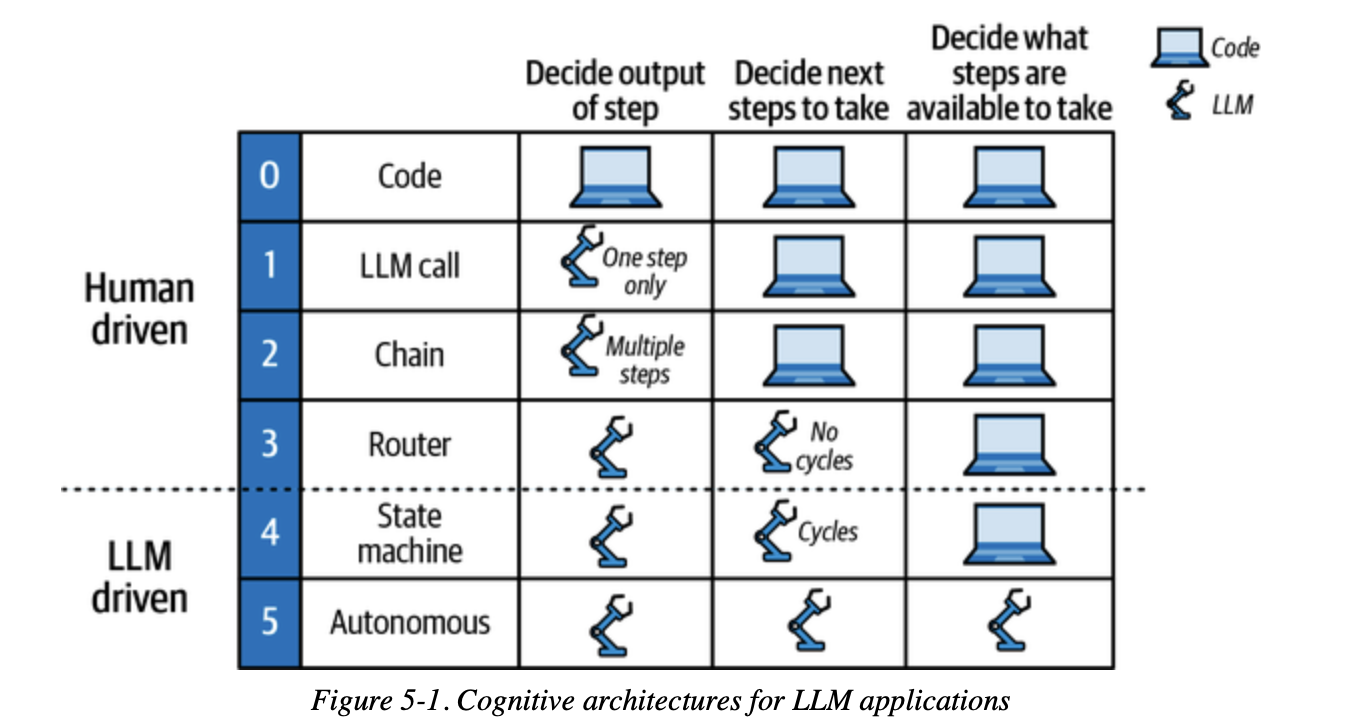

**Reference**

https://python.langchain.com/docs/integrations/chat/google_generative_ai/

https://python.langchain.com/docs/integrations/text_embedding/google_generative_ai/

https://colab.research.google.com/github/langfuse/langfuse-docs/blob/main/cookbook/integration_langgraph.ipynb#scrollTo=MKkM6mw47kIy

In [1]:
%%capture

%pip install -qU langchain-google-genai
%pip install langchain langchain-community langgraph duckduckgo-search

In [1]:
import os
import ast
from uuid import uuid4

from google.colab import userdata

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage, AIMessage, ToolCall
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_core.tools import tool as langchain_tool

from langchain_community.tools import DuckDuckGoSearchRun

from typing import Annotated, TypedDict, Literal

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

## Architecture #4: Reflection

In [2]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=userdata.get('GOOGLE_API_KEY')
)

In [3]:
class State(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]

In [13]:
generate_prompt = SystemMessage(
    "You are an essay assistant tasked with writing excellent 3-paragraph essays."
    " Generate the best essay possible for the user's request."
    " If the user provides critique, respond with a revised version of your previous attempts."
)

def generate(state: State) -> State:
  result = model.invoke([generate_prompt] + state["messages"])
  return {"messages": [result]}

In [19]:
reflection_prompt = SystemMessage(
    "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
    " Provide detailed recommendations, including requests for length, depth, style, etc."
)

def reflect(state: State) -> State:
  # Invert the messages to get the LLM to reflect on its own output
  cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
  # First message is the original user request. We hold it the same for all nodes
  translated = [reflection_prompt, state["messages"][0]] + [cls_map[msg.__class__](content=msg.content) for msg in state["messages"][1:]]
  result = model.invoke(translated)
  # We treat the output of this as human feedback for the generator
  return {"messages": [HumanMessage(content=result.content)]}

In [20]:
def should_continue(state: State):
  if len(state["messages"]) > 6:
    return END # End after 3 iterations, each with 2 messages
  else:
    return "reflect"

In [21]:
builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

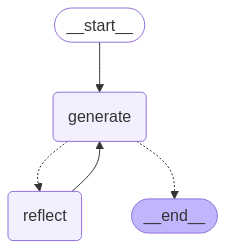

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
# let's run
initial_state = {
    "messages": [
        HumanMessage(content="Write an essay about the relevance of 'The Little Prince' today.")
    ]
}

# Run the graph
for output in graph.stream(initial_state):
    message_type = "generate" if "generate" in output else "reflect"
    print("\nNew message:", output[message_type]["messages"][-1].content[:100], "...")


New message: Antoine de Saint-Exupéry's "The Little Prince," though published in 1943, remains profoundly relevan ...

New message: Okay, here's a critique of your essay on the relevance of "The Little Prince" today, along with reco ...

New message: Okay, thank you for the thorough critique! I appreciate the specific recommendations and the revised ...

New message: Excellent! This is a significant improvement. The essay is now much more developed, insightful, and  ...

New message: Thank you again for the incredibly helpful and detailed feedback! I've incorporated your suggestions ...

New message: This is an excellent essay! You've successfully incorporated all the feedback and created a compelli ...

New message: Thank you so much for your guidance and encouragement throughout the revision process! I really appr ...


##Architecture #5: Always Calling Tool First

If you, the developer of the application, know that the search tool should always be called first, that can actually be beneficial to your application:



1. It will reduce overall latency, as it will skip the first LLM call that would generate that request to call the search tool.


2. It will prevent the LLM from erroneously deciding it doesn’t need to call the search tool for some user queries.



On the other hand, if your application doesn’t have a clear rule of the kind “you should always call this tool first,” introducing such a constraint would actually make your application worse.

In [ ]:
def first_model(state: State):
  query = state["messages"][-1].content
  search_tool_call = ToolCall(
      name="duckduckgo_search",
      args={"query": query},
      id=uuid4().hex
  )
  return {"messages": AIMessage(content="", tool_calls=[search_tool_call])}

In [ ]:
builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

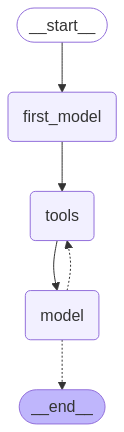

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# let's run
input = {
    "messages": [
        HumanMessage("How old was the 30th president of the United States when he died?")
    ]
}

In [ ]:
for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='3b94b692-c18c-4d29-a8c6-e908c1edec40', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'How old was the 30th president of the United States when he died?'}, 'id': '9e6940c427944d95856e2ed1e585e58d', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='Calvin Coolidge (born John Calvin Coolidge Jr.; [1] / ˈ k uː l ɪ dʒ / KOOL-ij; July 4, 1872 - January 5, 1933) was the 30th president of the United States, serving from 1923 to 1929.A Republican lawyer from Massachusetts, he previously served as the 29th vice president from 1921 to 1923 under President Warren G. Harding, and as the 48th governor of Massachusetts from 1919 to 1921. The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via

In [ ]:
input = {
    "messages": [
        HumanMessage("When Prime Minister Jawaharlal Nehru was dead?")
    ]
}

result = graph.invoke(input)
print(result["messages"][1].content)

In [ ]:
result["messages"][3].content

'Jawaharlal Nehru died on May 27, 1964.'

##Architecture #6: Dealing with Multiple Tools

One elegant solution is to use a RAG step to preselect the most relevant tools for the current query and then feed the LLM only that subset of tools instead of the entire arsenal. This can also help to reduce the cost of calling the LLM.

In [ ]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [ ]:
class State(TypedDict):
  # to track conversation history
  messages: Annotated[list, add_messages]
  selected_tools: list[str]

In [ ]:
tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools],
    embeddings,
).as_retriever()

In [ ]:
def model_node(state: State):
  selected_tools = [tool for tool in tools if tool.name in state["selected_tools"]]
  result = model.bind_tools(selected_tools).invoke(state["messages"])
  return {"messages": result}

In [ ]:
def select_tools(state: State) -> State:
  query = state["messages"][-1].content
  tool_docs = tools_retriever.invoke(query)
  return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}

In [ ]:
builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

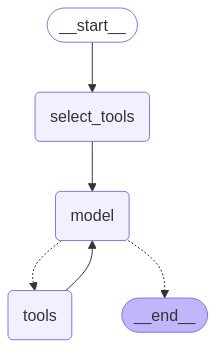

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# let's run
input = {
    "messages": [
        HumanMessage("How old was the 30th president of the United States when he died?")
    ]
}

In [ ]:
for c in graph.stream(input):
    print(c)

{'select_tools': {'selected_tools': ['duckduckgo_search', 'calculator']}}
{'model': {'messages': AIMessage(content='Could you please provide me with the name of the 30th president of the United States? Once I have that information, I can look up his birth and death dates and calculate his age at the time of his death.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-5f4954d2-c8b9-4346-87d6-4f6929eac94f-0', usage_metadata={'input_tokens': 71, 'output_tokens': 47, 'total_tokens': 118, 'input_token_details': {'cache_read': 0}})}}


In [ ]:
input = {
    "messages": [
        HumanMessage("When Prime Minister Jawaharlal Nehru was dead?")
    ]
}

result = graph.invoke(input)

In [ ]:
print(result["messages"][3].content)

Jawaharlal Nehru died on May 27, 1964.
